# Import packages

In [1]:
# Import Packages and setup
import logging
import os

import numpy as np

import scarlet
import scarlet.display
from scarlet.config import Normalization

# For display purposes
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

# Load and display the data

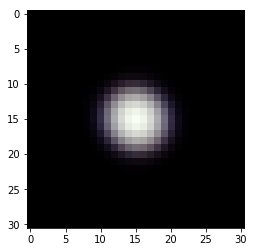

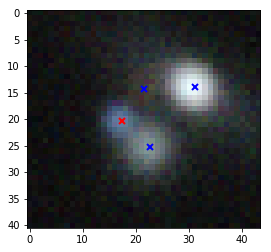

In [2]:
# This uses data from the testdata_deblender package, available at
# https://github.com/lsst/testdata_deblender
# You don't have to actually install the package, which requires the entire
# LSST stack, but you have to clone it from github
# Changing `idx` modifies the 
idx = 4
filter_indices = [3,2,1]
# Use this to point to the location of the data on your system
datapath = "/Users/fmoolekamp/data/testdata_deblender/sim_data/unmatched_sim"
# Uncomment the following line to use PSF matched images
#datapath = "/Users/fmoolekamp/data/testdata_deblender/sim_data/psf_matched_sim"
psfs = np.load(os.path.join(datapath, "psfs.npz"))["psfs"]
data = np.load(os.path.join(datapath, "images_{0}.npz".format(idx)))
images = data["images"]
filters = data["filters"]

from astropy.table import Table as ApTable
catalog = ApTable.read(os.path.join(datapath, "true_catalog_{0}.fits".format(idx)))
# Only use a single component for each source
catalog = catalog[catalog["component"]!="disk"]
bg_rms = np.array([20]*len(images))

# display psfs
pnorm = scarlet.display.Asinh(img=psfs, Q=20)
prgb = scarlet.display.img_to_rgb(psfs, filter_indices=filter_indices, norm=pnorm)
plt.imshow(prgb)
plt.show()

# Use Asinh scaling for the images
norm = scarlet.display.Asinh(img=images, Q=20)
# Map i,r,g -> RGB
# Convert the image to an RGB image
img_rgb = scarlet.display.img_to_rgb(images, filter_indices=filter_indices, norm=norm)
plt.imshow(img_rgb)
for src in catalog:
    if src["is_star"]:
        plt.plot(src["x"], src["y"], "rx", mew=2)
    else:
        plt.plot(src["x"], src["y"], "bx", mew=2)
plt.show()

# Fit the PSFs

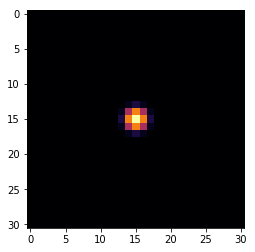

In [3]:
# Get the target PSF to partially deconvolve the image psfs
target_psf = scarlet.psf_match.fit_target_psf(psfs, scarlet.psf_match.moffat)
# Display the target PSF
plt.imshow(target_psf,norm=scarlet.display.Asinh(img=target_psf))
plt.show()
# Match each PSF to the target PSF
diff_kernels, psf_blend = scarlet.psf_match.build_diff_kernels(psfs, target_psf)

# Initialize the source as Point Source

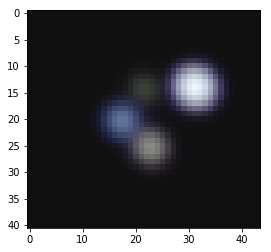

In [4]:
import scarlet.constraint as sc

# You must turn off acceleration and set the normalization to Normalization.S for this
# to work properly.
config = scarlet.config.Config(refine_skip=2, accelerated=False, normalization=Normalization.S)

# This is the constraint to use for a point source, which doesn't
# require the more complicated constraints used for extended sources
constraints = (
    sc.SimpleConstraint(config.normalization)
)

# The key here is to set `fix_morph` to true, which tells it to always use the
# initial morphology, which in this case is a single point that is later convolced
# with the PSF to generate the model.
sources = [
    scarlet.PointSource(
        (src['y'],src['x']), # Note the y coordinate comes first
        images,
        constraints=constraints, # use the correct constraints
        psf=psfs, # only required if the images aren't already PSF matched
        shape=psfs[0].shape,
        fix_morph=True, # This is required to model a point source
        config=config)
    for src in catalog
]

# Initialize the Blend object, which later fits the model
blend = scarlet.Blend(sources)
blend.set_data(images, bg_rms=bg_rms, config=config)

# Display the initial model
model = blend.get_model()
img_rgb = scarlet.display.img_to_rgb(model, filter_indices=[3,2,1], norm=norm)
plt.imshow(img_rgb)
plt.show()

# Fit the model and display the results

In [5]:
blend.fit(100)
print("Fit for {0} iterations".format(blend.it))



plt.show()

Fit for 4 iterations


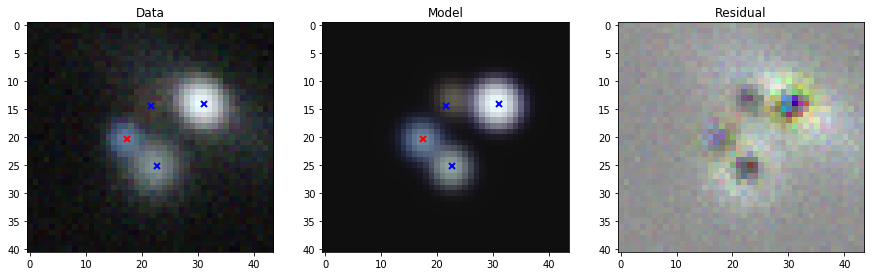

In [6]:
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]

# Display the data
img_rgb = scarlet.display.img_to_rgb(images, filter_indices=filter_indices, norm=norm)
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
for src in catalog:
    if src["is_star"]:
        ax[0].plot(src["x"], src["y"], "rx", mew=2)
    else:
        ax[0].plot(src["x"], src["y"], "bx", mew=2)

#Display the model
model = blend.get_model()
img_rgb = scarlet.display.img_to_rgb(model, filter_indices=[3,2,1], norm=norm)
ax[1].imshow(img_rgb)
ax[1].set_title("Model")
for src in catalog:
    if src["is_star"]:
        ax[1].plot(src["x"], src["y"], "rx", mew=2)
    else:
        ax[1].plot(src["x"], src["y"], "bx", mew=2)

# Display the residual
residual = images-model
img_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices)
ax[2].imshow(img_rgb)
ax[2].set_title("Residual")

# Show the plots
plt.show()